In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import os
import sys
sys.path.insert(0,'../st_validate/')
import sta_validate
import histology
import apsym_kmeans
import matplotlib.pyplot as plt
from periodic_kmeans.periodic_kmeans import PeriodicKMeans


# Generate a 3D phantom

## Set the phantom parameters

In [7]:
# load presaved angles from file
angles = np.load('../3d_angles.npy')
idx = np.random.randint(0,len(angles), size=2)

# choose a random pair of directions from angles
true_angles = np.stack((angles[idx[0]], angles[idx[1]]))

# or a single random direction from angles
# true_angles = np.array([angles[idx[0]]])
print(f'angle: {true_angles}')

# set the image dimensions
shape = (36,72,72)
dI = (shape[1]/shape[0], 1.0, 1.0)
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# set the period (distance between parallel lines)
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

angle: [[1.74757812 2.50827703]
 [2.56873323 0.56131252]]


## Generate the phantom and do anisotropy correction

In [8]:
# generate phantom with anisotropic pixel sizes
image_3d = sta_validate.make_phantom(x, true_angles, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_3d = sta_validate.anisotropy_correction(image_3d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_3d = sta_validate.anisotropy_correction(image_3d, dI=dI, blur=True)

## Visualize

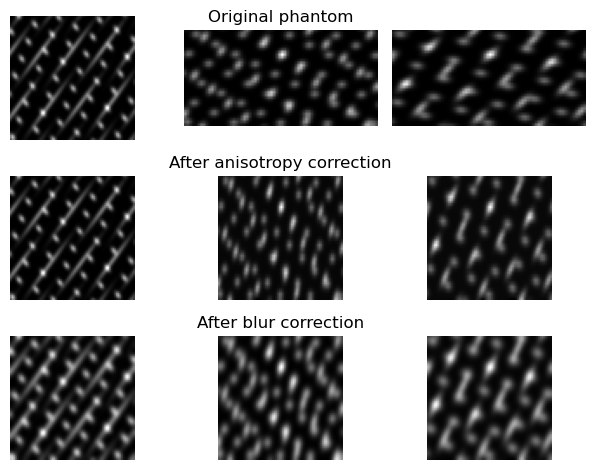

In [9]:
fig, ax = plt.subplots(3,3, tight_layout=True)

ax[0,0].imshow(image_3d[image_3d.shape[0]//2], cmap='gray')
ax[0,1].imshow(image_3d[:, image_3d.shape[1]//2], cmap='gray')
ax[0,1].set_title('Original phantom')
ax[0,2].imshow(image_3d[..., image_3d.shape[2]//2], cmap='gray')
ax[1,0].imshow(image_iso_3d[image_iso_3d.shape[0]//2], cmap='gray')
ax[1,1].imshow(image_iso_3d[:, image_iso_3d.shape[1]//2], cmap='gray')
ax[1,1].set_title('After anisotropy correction')
ax[1,2].imshow(image_iso_3d[..., image_iso_3d.shape[2]//2], cmap='gray')
ax[2,0].imshow(image_iso_blur_3d[image_iso_blur_3d.shape[0]//2], cmap='gray')
ax[2,1].imshow(image_iso_blur_3d[:, image_iso_blur_3d.shape[1]//2], cmap='gray')
ax[2,1].set_title('After blur correction')
ax[2,2].imshow(image_iso_blur_3d[..., image_iso_blur_3d.shape[2]//2], cmap='gray')

for a in ax.flatten():
    a.axis('off')

## Perform structure tensor analysis

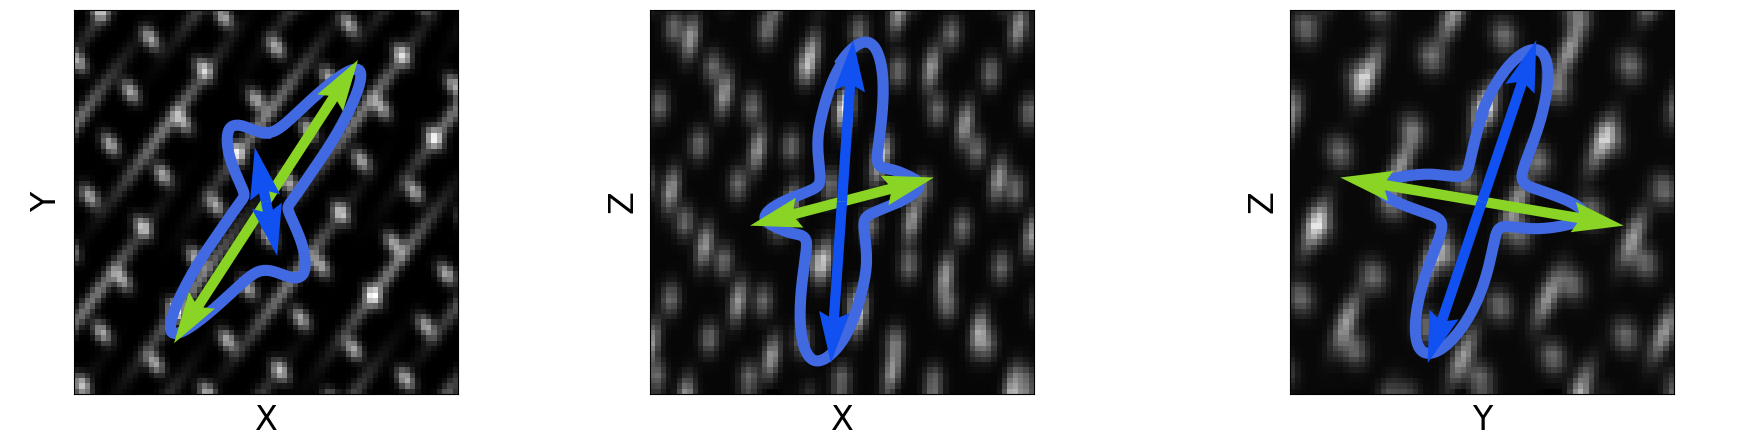

true angles: [[ 0.58259696 -0.79350689 -0.17586244]
 [ 0.28852519  0.45886548 -0.8403545 ]]
estimated angles: [[ 0.53911931 -0.83032355 -0.14111405]
 [-0.06532494 -0.31821573  0.94576498]]
mean error (degrees): 10.078550726451887


In [10]:
I = image_iso_3d
sigma_g = 1.0
sigma_w = 2.0

S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
angles = histology.angles(S, cartesian=True)
angles = angles.reshape(-1,3)

true_angles_ = np.array([np.sin(true_angles[:,0])*np.sin(true_angles[:,1]),
                                np.sin(true_angles[:,0])*np.cos(true_angles[:,1]),
                                np.cos(true_angles[:,0])
                                ]).T
if len(true_angles_) == 1:
    skm = apsym_kmeans.APSymKMeans(n_clusters=1)
    skm.fit(angles)
    means = skm.cluster_centers_
    diff = np.arccos(np.abs(means.dot(true_angles_.T))) * 180/np.pi

elif len(true_angles_) == 2:
    skm = apsym_kmeans.APSymKMeans(n_clusters=2)
    skm.fit(angles)
    means = skm.cluster_centers_ # shape (n_clusters, n_features)
    diff_ = np.empty((len(means),len(true_angles_))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(means)):
        for n in range(len(true_angles_)):
            diff_[m,n] = np.arccos(np.abs(means[m].dot(true_angles_[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi

histology.plot_angles_3d(I, vectors=angles, means=means)

print(f'true angles: {true_angles_}')
print(f'estimated angles: {means}')
print(f'mean error (degrees): {diff}')

# Generate a 2D phantom

## Set the phantom parameters

In [2]:
# Choose two angles
# true_angles = [np.pi/3, 0.0]

# or one angle
true_angles = [0.0]

# set the image dimensions
shape = (96,96)
dI = (shape[1]/shape[0], 1.0)
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# set the period (distance between parallel lines)
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

## Generate the phantom and do anisotropy correction

In [3]:
# generate phantom with anisotropic pixel sizes
image_2d = sta_validate.make_phantom(x, true_angles, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_2d = sta_validate.anisotropy_correction(image_2d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_2d = sta_validate.anisotropy_correction(image_2d, dI=dI, blur=True)

## Visualize

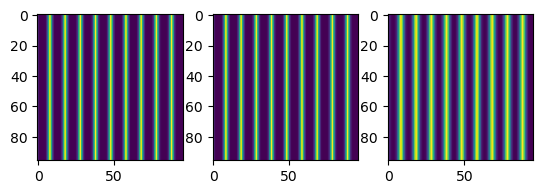

In [4]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_2d)
ax[1].imshow(image_iso_2d)
ax[2].imshow(image_iso_blur_2d)

# Perform structure tensor analysis on a 2D phantom

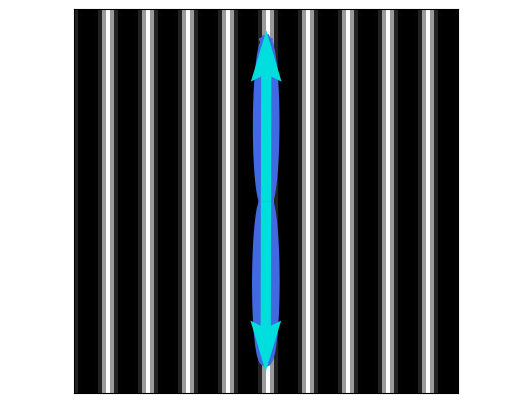

true angles: [0.0]
estimated angles: [3.13965392]
mean error (degrees): 0.11108096929608832


In [5]:
I = image_iso_2d
sigma_g = 0.4
sigma_w = 4.0

S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
angles = histology.angles(S)

angles = angles.flatten()[..., None]
angles = np.where(angles < 0, angles + np.pi, angles) # flip angles to be in the range [0,pi] for periodic kmeans

if len(true_angles) == 1:
    means = histology.periodic_mean(angles.flatten()[...,None], period=np.pi)
else:
    periodic_kmeans = PeriodicKMeans(angles.flatten()[..., None], period=np.pi, no_of_clusters=2)
    _, _, centers = periodic_kmeans.clustering()
    means = np.array(centers).squeeze()

histology.plot_angles(I, angles=angles, means=means, colors=means)

print(f'true angles: {true_angles}')
print(f'estimated angles: {means}')

# compute error
mu_flipped = np.where(means < 0, means + np.pi, means - np.pi)
mu = np.stack((means,mu_flipped), axis=-1)
diff_ = np.abs(mu[...,None] - true_angles) # this has shape (2,2,2) for 2 mu values each with 2 possible orientations, and each compared to both ground truth angles
if len(true_angles) == 1:
    diff = np.min(diff_) * 180/np.pi
else:
    argmin = np.array(np.unravel_index(np.argmin(diff_), (2,2,2))) # the closest mu value and orientation is the first error
    remaining_idx = 1 - argmin # the second error is the best error from the other mu value compared to the other ground truth angle
    diff = np.mean([diff_[tuple(argmin)], np.min(diff_,1)[remaining_idx[0],remaining_idx[2]]]) * 180/np.pi

print(f'mean error (degrees): {diff}')

## Compute ST analysis error in one line using sta_test

In [11]:
error = sta_validate.sta_test(image_iso_3d, derivative_sigma=sigma_g, tensor_sigma=sigma_w, true_thetas=true_angles)
print(error)

10.062344126073711


## Compute ST analysis tests on a series of phantoms

In [10]:
derivative_sigmas = np.linspace(start=0.5, stop=1.5, num=3)
tensor_sigmas = np.linspace(start=1.0, stop=3.0, num=3)
nIs = [(96,96), (48,96), (32,96)]
periods=[10]
angles=[[np.pi/3,-np.pi/6], [np.pi/3, 0.0], [np.pi/3, np.pi/6]]

error_df = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=nIs, periods=periods, angles=angles)

print(error_df[:12])

  0%|          | 0/9 [00:00<?, ?it/s]

    derivative_sigma  tensor_sigma  anisotropy_ratio  period  \
0                0.5           1.0               1.0    10.0   
1                0.5           2.0               1.0    10.0   
2                0.5           3.0               1.0    10.0   
3                1.0           1.0               1.0    10.0   
4                1.0           2.0               1.0    10.0   
5                1.0           3.0               1.0    10.0   
6                1.5           1.0               1.0    10.0   
7                1.5           2.0               1.0    10.0   
8                1.5           3.0               1.0    10.0   
9                0.5           1.0               1.0    10.0   
10               0.5           2.0               1.0    10.0   
11               0.5           3.0               1.0    10.0   

                                       angles      error  width  
0   [1.0471975511965976, -0.5235987755982988]   7.037629    1.0  
1   [1.0471975511965976, -0.5235987

In [11]:
error_df

,derivative_sigma,tensor_sigma,anisotropy_ratio,period,angles,error,width
0,0.5,1.0,1.0,10.0,"[1.0471975511965976, -0.5235987755982988]",7.037629,1.0
1,0.5,2.0,1.0,10.0,"[1.0471975511965976, -0.5235987755982988]",0.955683,1.0
2,0.5,3.0,1.0,10.0,"[1.0471975511965976, -0.5235987755982988]",1.714869,1.0
3,1.0,1.0,1.0,10.0,"[1.0471975511965976, -0.5235987755982988]",44.526006,1.0
4,1.0,2.0,1.0,10.0,"[1.0471975511965976, -0.5235987755982988]",2.525463,1.0
...,...,...,...,...,...,...,...
76,1.0,2.0,3.0,10.0,"[1.0471975511965976, 0.5235987755982988]",19.951582,1.0
77,1.0,3.0,3.0,10.0,"[1.0471975511965976, 0.5235987755982988]",18.713324,1.0
78,1.5,1.0,3.0,10.0,"[1.0471975511965976, 0.5235987755982988]",21.560910,1.0
79,1.5,2.0,3.0,10.0,"[1.0471975511965976, 0.5235987755982988]",19.835902,1.0
